Set Colab to GPU Mode if you are training the models!

### Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd 'drive/MyDrive/IIT J Summer Internship 2022/Code/Neural-Uncertainty-Representation/'

/content/drive/.shortcut-targets-by-id/1h_oF16bG32l75GPobgHe_9HgdUduLFxT/IIT J Summer Internship 2022/Code/Neural-Uncertainty-Representation


### Importing Necessary Libraries


In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, LSTM, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import os

### Importing Data
We import the data of a young subject's 3D-Tensor Data of dimensions (TR, Voxel, Number of Subjects) for the 5 different ROIs as follows:
- **Prefrontal areas:** dlPFC, vlPFC, lOFC, dmPFC, mPFC, mOFC
- **Default-mode areas:** mPFC, ACC, PCC, Precuneus, mOFC
- **Sensory areas:** VC
- **Multisensory area:** pSTS
- **Some other areas:** TP, IPL, mCC, Put, PCG, Nac, INS





In [4]:
file_names = [name for name in os.listdir('/content/drive/MyDrive/IIT J Summer Internship 2022/Hitchcock/Data/YOUNG/Voxel_BOLD/Numpy') if name.endswith("npy") and ("(1)" not in name)]
file_names = [name for name in file_names if ("537" not in name)]

In [5]:
ROI_names = [file_name.replace("data_","").replace(".npy","") for file_name in file_names]

In [6]:
data_ori = list()
for file_name in file_names:
  data_ori.append(np.load('/content/drive/MyDrive/IIT J Summer Internship 2022/Hitchcock/Data/YOUNG/Voxel_BOLD/Numpy/'+file_name))

### Data Preparation

Now, here we prepare the data to be fed to the Neural Network Architechtures. We can't predict the time ahead upto which the subjects are predicting correctly so, we will take a bit round about way to predict the BOLD values ahead in time(for several choices of time points e.g. 1 time point ahead, 2 time point ahead, etc) and will compare the results for young and old subjects.

Right from the starting we decide some of the data preparation parameters, so that we can use them as we require.

In [7]:
TRAIN_BATCH_SIZE = 20
TEST_BATCH_SIZE = 10
LOOK_AHEAD = 1
NUM_TEST_SUBS = 10

We will avoid doing an average since, all voxels in a ROI is not equally important and hence we will want to predict the BOLD values of several voxels simultaneously.

In [8]:
data = data_ori

Let's Start the Data Preparation for lOFC later we will iterate the same procedure for the other ROIs.

In [9]:
print(ROI_names[-1], "BOLD Shape:", data[-1].shape)

lOFC BOLD Shape: (189, 537, 111)


Below, we see the BOLD time series plot for all the ROIs.

We have changed the data in the form (Number of Subjects, TR, Voxels) below.

In [10]:
data = [np.transpose(dat, (2,0,1)) for dat in data]

In [11]:
print(ROI_names[-1], "BOLD Shape:", data[-1].shape)

lOFC BOLD Shape: (111, 189, 537)


In [12]:
# for i in range(len(data)):  
#   plt.figure(figsize=(10, 8))
#   plt.plot(data[i][0,:,:])
#   plt.title("BOLD of 1st Subject for "+ROI_names[i]+"'s Voxels")
#   plt.xlabel("TRs")
#   plt.ylabel("BOLD")
#   plt.savefig("./Plots/YOUNG/ALL-BOLD/ALL-BOLD-"+ROI_names[i]+".png")

We split the dataset of 111 young subjects into 101 subjects in the training data and 10 subject in the test data.

In [13]:
train_data_unscaled = [dat[:-NUM_TEST_SUBS] for dat in data]
test_data_unscaled = [dat[-NUM_TEST_SUBS:] for dat in data]  

We scaled the BOLD values of each voxel in the train data between 0 and 1 for each voxel. We use the same MinMaxScaler fit on the train data on the test data.

In [14]:
scalers = dict() # Stores a list of MinMaxScalers for each ROI, where number of MinMaxScalers is equal to the number of voxels in that ROI
for i in range(len(ROI_names)):
  scalers[ROI_names[i]] = [MinMaxScaler(feature_range = (0, 1)) for _ in range(data[i].shape[-1])]

train_data = [[scalers[ROI_names[j]][i].fit_transform(train_data_unscaled[j][:,:,i]) for i in range(len(scalers[ROI_names[j]]))] for j in range(len(ROI_names))]
test_data = [[scalers[ROI_names[j]][i].transform(test_data_unscaled[j][:,:,i]) for i in range(len(scalers[ROI_names[j]]))] for j in range(len(ROI_names))]

In [15]:
train_data = [np.transpose(np.array(dat), (1,2,0)) for dat in train_data]
test_data = [np.transpose(np.array(dat), (1,2,0)) for dat in test_data]

In [16]:
print(ROI_names[-1], "Train Data Shape: ", train_data[-1].shape)
print(ROI_names[-1], "Test Data Shape: ", test_data[-1].shape)

lOFC Train Data Shape:  (101, 189, 537)
lOFC Test Data Shape:  (10, 189, 537)


In [17]:
# for i in range(len(data)):  
#   plt.figure(figsize=(10, 8))
#   plt.plot(train_data[i][0,:,:])
#   plt.title("BOLD of 1st Subject for "+ROI_names[i]+"'s Voxels")
#   plt.xlabel("TRs")
#   plt.ylabel("BOLD[Scaled between 0 and 1]")
#   plt.savefig("./Plots/YOUNG/ALL-BOLD/ALL-BOLD-SCALED-"+ROI_names[i]+".png")

We now build a data generator which would produce mini-batches during the training of the neural network.

In [18]:
class KerasBatchGenerator(object):
    def __init__(self, data, num_TRs, batch_size, look_ahead=1):
        self.data = data
        self.num_TRs = num_TRs
        self.batch_size = batch_size
        self.current_idx = 0
        self.look_ahead = look_ahead

    def generate(self):
        while True:
            if self.current_idx + self.batch_size >= self.data.shape[0]:
              self.current_idx = 0
            x = self.data[self.current_idx:(self.current_idx+self.batch_size),:(-self.look_ahead),:]
            y = self.data[self.current_idx:(self.current_idx+self.batch_size),self.look_ahead:,:]
            self.current_idx = self.current_idx + self.batch_size
            yield x, y 

In [19]:
train_data_generator = [KerasBatchGenerator(dat, dat.shape[1], TRAIN_BATCH_SIZE, LOOK_AHEAD) for dat in train_data]
test_data_generator = [KerasBatchGenerator(dat, dat.shape[1], TEST_BATCH_SIZE, LOOK_AHEAD) for dat in test_data]

In [20]:
batch_x, batch_y = next(train_data_generator[-1].generate())
print(ROI_names[-1], "Train Batch X Shape: ", batch_x.shape)
print(ROI_names[-1], "Train Batch y Shape: ", batch_y.shape)

lOFC Train Batch X Shape:  (20, 188, 537)
lOFC Train Batch y Shape:  (20, 188, 537)


In [21]:
batch_x, batch_y = next(test_data_generator[-1].generate())
print(ROI_names[-1], "Test Batch X Shape: ", batch_x.shape)
print(ROI_names[-1], "Test Batch y Shape: ", batch_y.shape)

lOFC Test Batch X Shape:  (10, 188, 537)
lOFC Test Batch y Shape:  (10, 188, 537)


### Building Model

We will start off by building a LSTM Model:
- `Number of LSTM Layers = 2`
- `Number of Dense Layers = 2`
- `hidden units = 32`
- `dropout = 0.3`

In [22]:
HIDDEN_UNITS = 16
DROPOUT_PROB = 0.3
LSTM_LAYERS = 2
DENSE_LAYERS = 4

In [23]:
def avg_bold_model(num_voxs):
  model = Sequential()
  for _ in range(LSTM_LAYERS):
    model.add(LSTM(HIDDEN_UNITS, return_sequences=True))
  model.add(Dropout(0.3))
  for _ in range(DENSE_LAYERS-1):
    model.add(TimeDistributed(Dense(HIDDEN_UNITS, activation='relu')))
  model.add(TimeDistributed(Dense(num_voxs)))
  return model

In [24]:
sample_model = avg_bold_model(batch_x.shape[-1])
sample_model.build(input_shape=batch_x.shape)
sample_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (10, 188, 16)             35456     
                                                                 
 lstm_1 (LSTM)               (10, 188, 16)             2112      
                                                                 
 dropout (Dropout)           (10, 188, 16)             0         
                                                                 
 time_distributed (TimeDistr  (10, 188, 16)            272       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (10, 188, 16)            272       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (10, 188, 16)            2

In [25]:
models = [avg_bold_model(train_data[i].shape[-1]) for i in range(len(ROI_names))]

#### Training Model

If you haven't already trained the models then uncomment and train your models which will be saved and will be loaded for inference later.

In [26]:
for i in range(len(ROI_names)):
  models[i].compile(optimizer = 'adam', loss = 'mean_squared_error')

In [27]:
EPOCHS = 100
checkpoint_filepaths = [f"./Models/YOUNG/LSTM/ALL-BOLD/{name}/model_weights-best-val-loss-{LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop-{LOOK_AHEAD}Ahead-{name}" for name in ROI_names]
model_checkpoint_callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "val_loss",
    mode='min',
    save_best_only=True) for checkpoint_filepath in checkpoint_filepaths]

In [28]:
def plot_train_test_loss(history, model_name, i):  
  plt.figure(figsize=(10,10))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(model_name+' loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig("./Plots/YOUNG/LSTM/ALL-BOLD/"+ROI_names[i]+"/"+model_name+"-loss.png")

Epoch 1/100
5/5 [==============================] - 8s 969ms/step - loss: 0.2670 - val_loss: 0.2609
Epoch 2/100
5/5 [==============================] - 0s 57ms/step - loss: 0.2518 - val_loss: 0.2394
Epoch 3/100
5/5 [==============================] - 0s 61ms/step - loss: 0.2253 - val_loss: 0.2032
Epoch 4/100
5/5 [==============================] - 0s 54ms/step - loss: 0.1861 - val_loss: 0.1590
Epoch 5/100
5/5 [==============================] - 0s 54ms/step - loss: 0.1439 - val_loss: 0.1169
Epoch 6/100
5/5 [==============================] - 0s 59ms/step - loss: 0.1084 - val_loss: 0.0868
Epoch 7/100
5/5 [==============================] - 0s 56ms/step - loss: 0.0864 - val_loss: 0.0666
Epoch 8/100
5/5 [==============================] - 0s 55ms/step - loss: 0.0693 - val_loss: 0.0497
Epoch 9/100
5/5 [==============================] - 0s 55ms/step - loss: 0.0553 - val_loss: 0.0396
Epoch 10/100
5/5 [==============================] - 0s 63ms/step - loss: 0.0475 - val_loss: 0.0360
Epoch 11/100
5/5 [

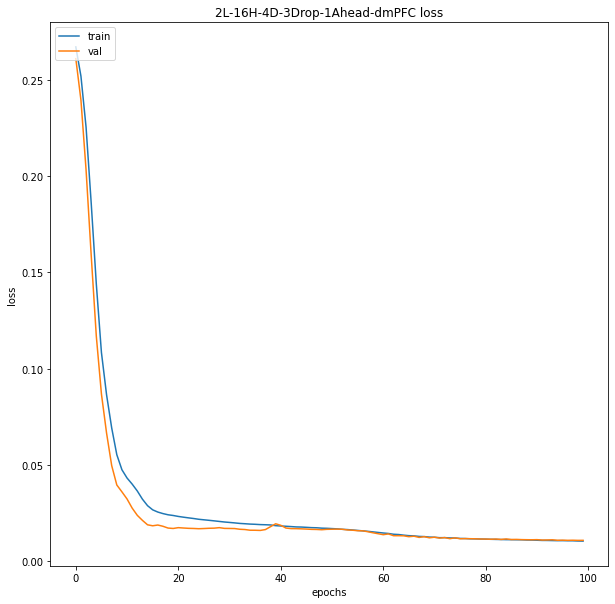

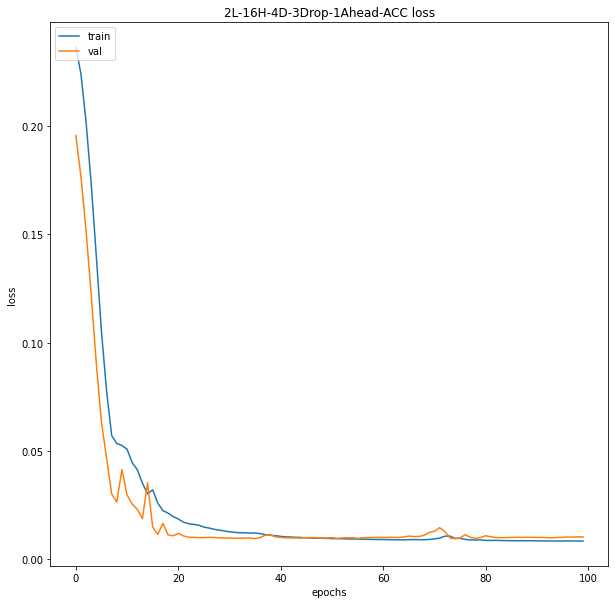

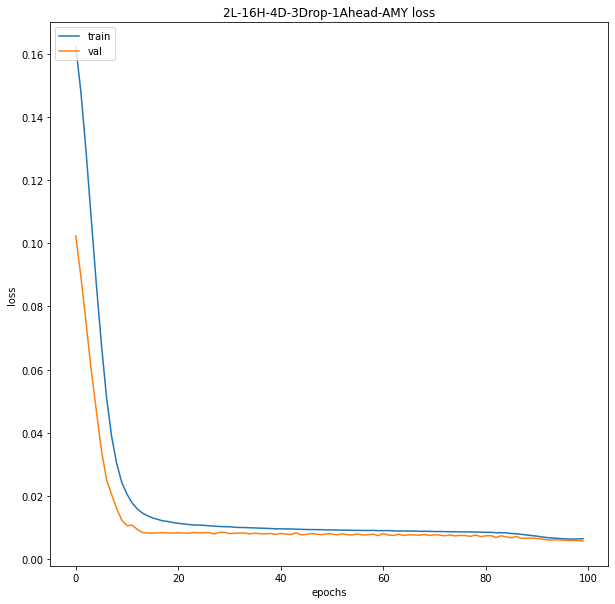

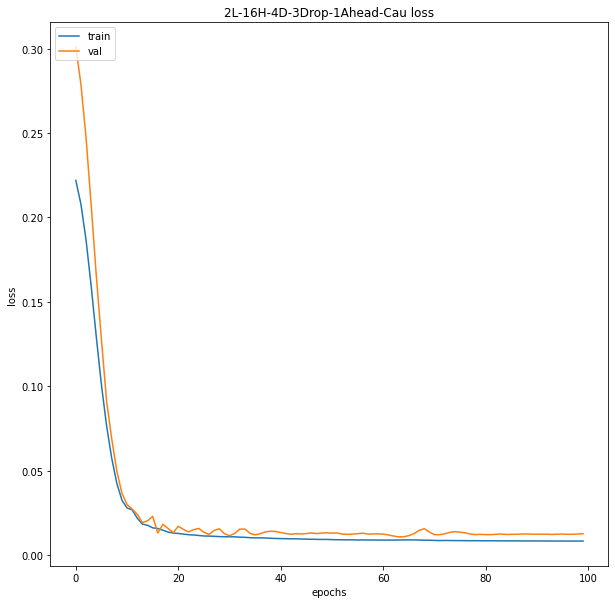

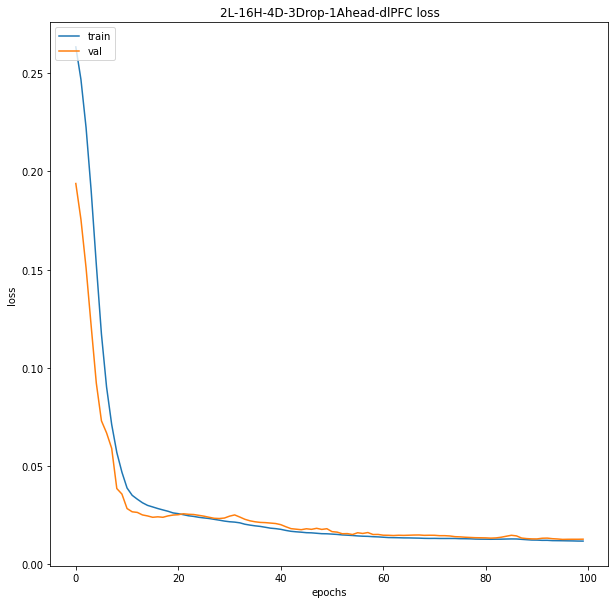

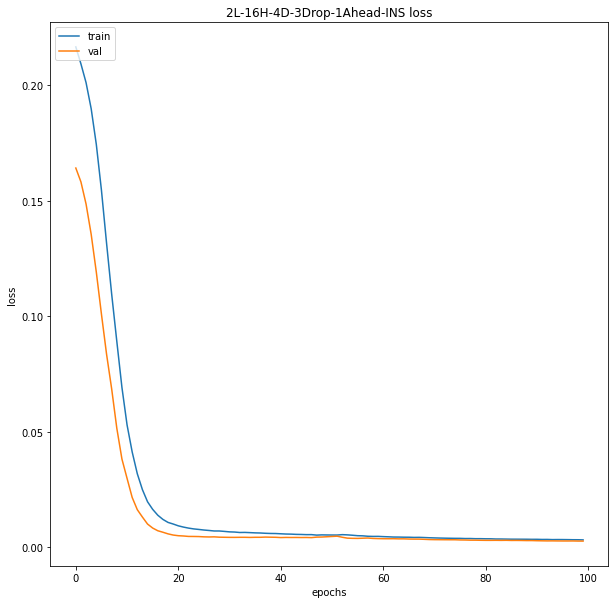

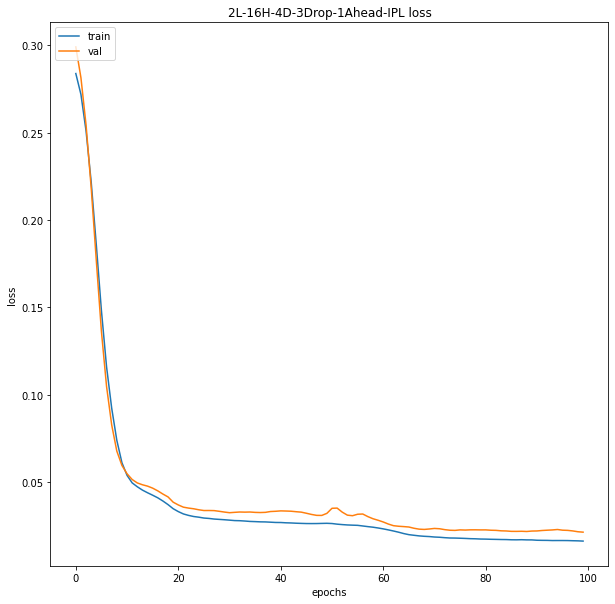

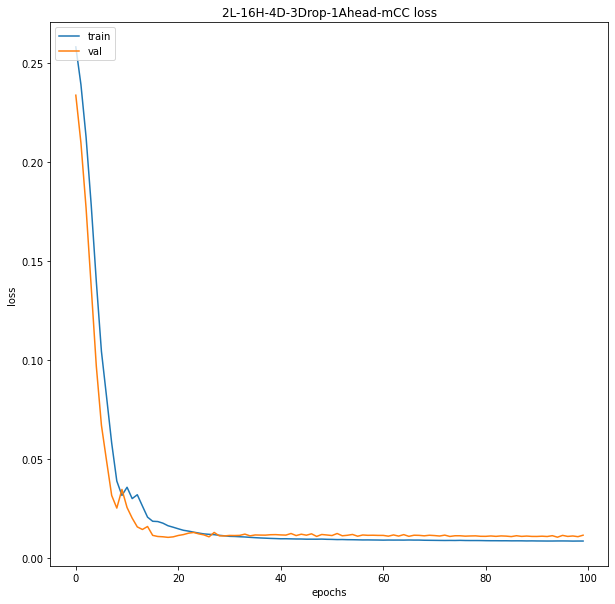

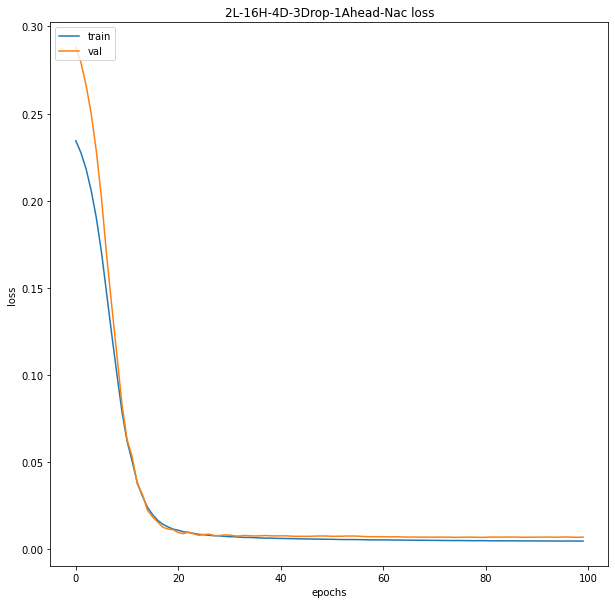

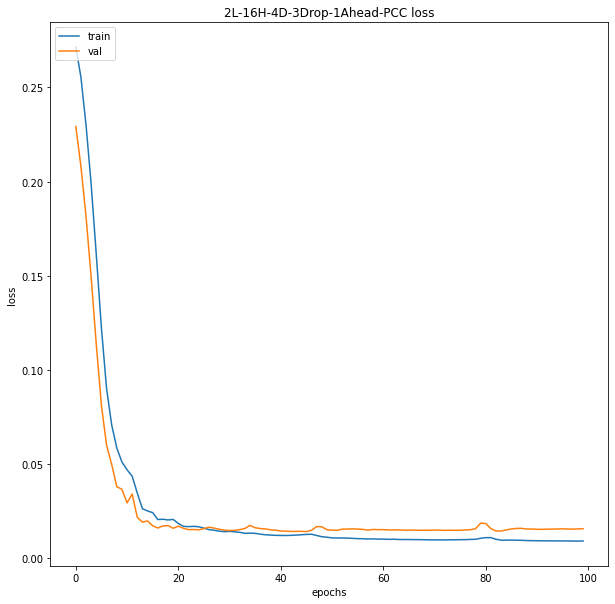

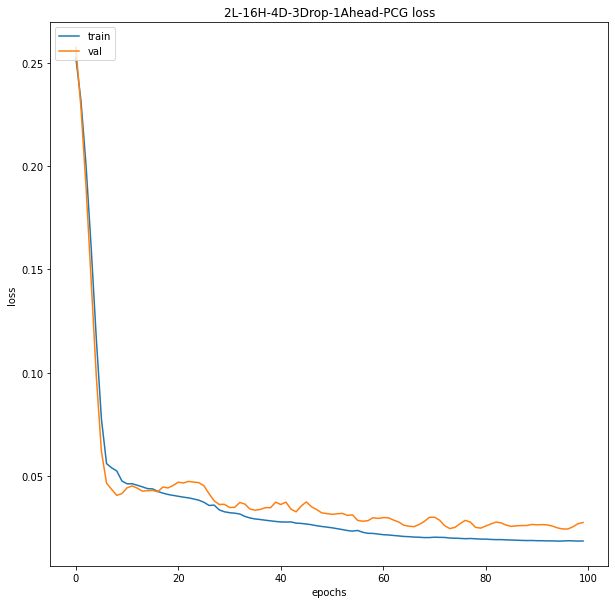

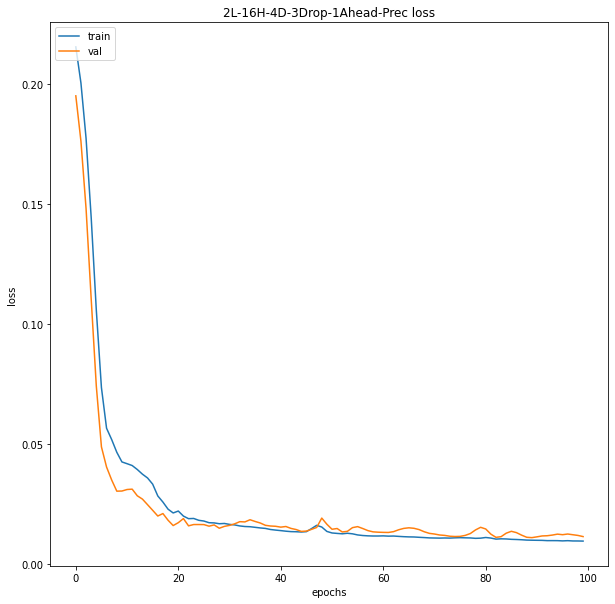

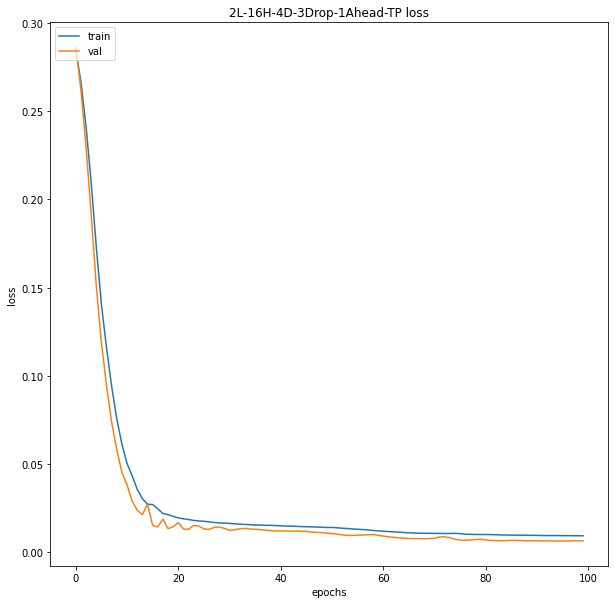

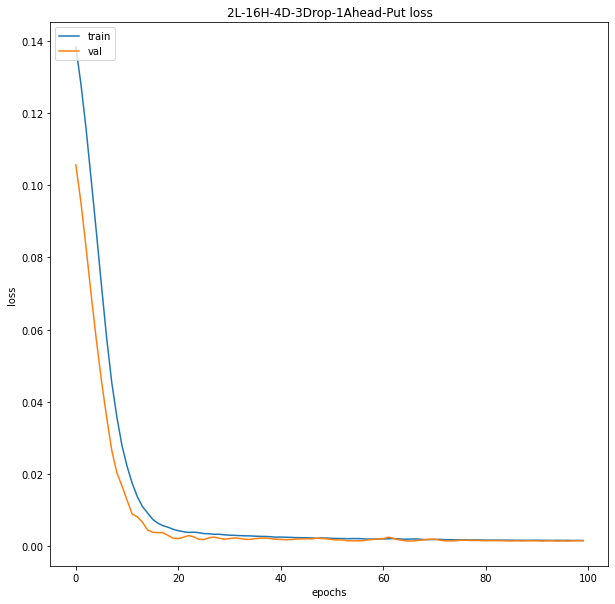

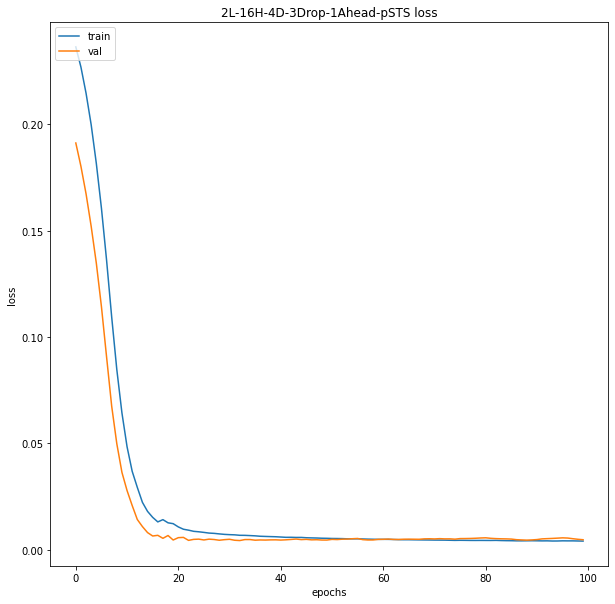

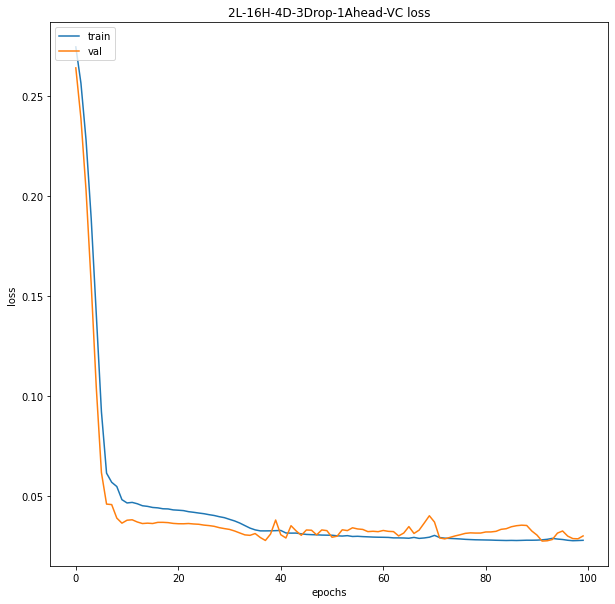

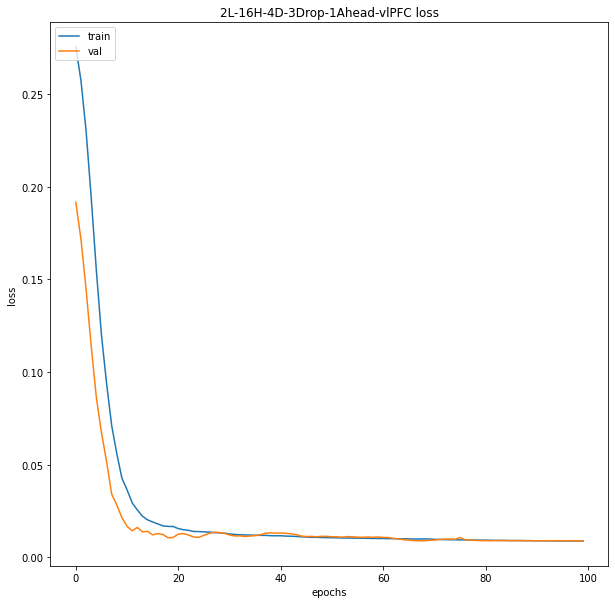

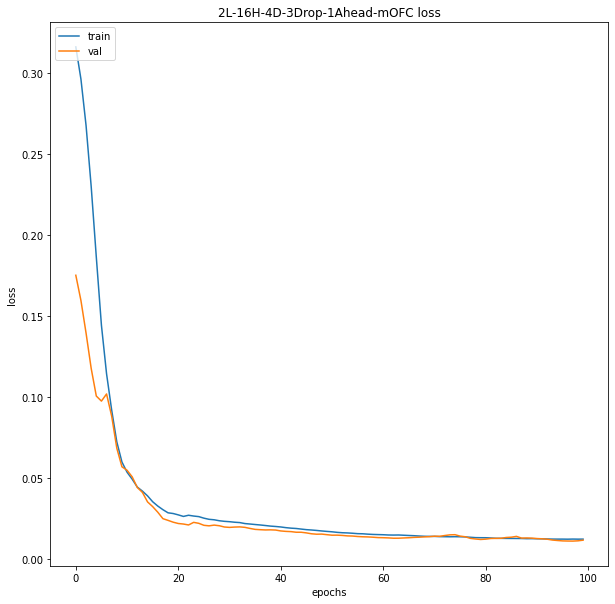

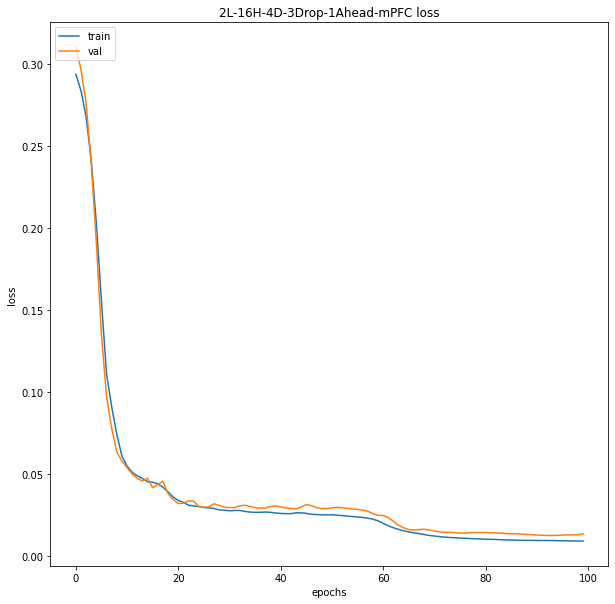

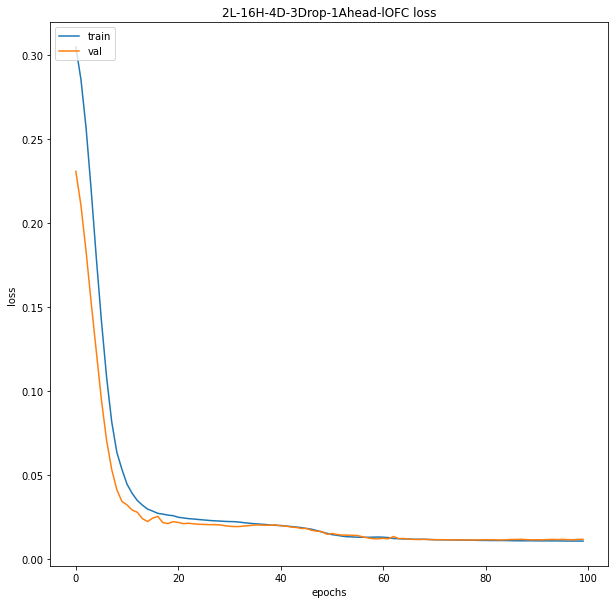

In [29]:
histories = list()
with tf.device('/device:GPU:0'):
  for i in range(len(ROI_names)):
    history = models[i].fit(
                    train_data_generator[i].generate(),
                    steps_per_epoch=train_data[i].shape[0]//TRAIN_BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=test_data_generator[i].generate(),
                    validation_steps=test_data[i].shape[0]//TEST_BATCH_SIZE,
                    callbacks=[model_checkpoint_callbacks[i]]
                    )
    models[i].save_weights(f"./Models/YOUNG/LSTM/ALL-BOLD/{ROI_names[i]}/model_weights-{LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop-{LOOK_AHEAD}Ahead-{ROI_names[i]}")
    plot_train_test_loss(history, f"{LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop-{LOOK_AHEAD}Ahead-{ROI_names[i]}", i)
    histories.append(history)

In [30]:
for i in range(len(ROI_names)):
  models[i].load_weights(f"./Models/YOUNG/LSTM/ALL-BOLD/{ROI_names[i]}/model_weights-{LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop-{LOOK_AHEAD}Ahead-{ROI_names[i]}")

In [31]:
preds = [models[i].predict(next(test_data_generator[i].generate())[0]) for i in range(len(ROI_names))]

In [32]:
a_TRs = np.array([56, 67, 73, 81, 134, 142, 155, 167, 174, 180])
d_TRs = np.array([67, 72, 85, 89, 145, 154, 168, 174, 180, 188])
and_TRs = np.union1d(a_TRs, d_TRs)

def highlight_and(act, pred):
  min_y_list = list()
  max_y_list = list()
  for i in range(5):
    min_y_list.append(np.min(np.concatenate([act[a_TRs[2*i]:d_TRs[2*i+1]], pred[a_TRs[2*i]:d_TRs[2*i+1]]])))
    max_y_list.append(np.max(np.concatenate([act[a_TRs[2*i]:d_TRs[2*i+1]], pred[a_TRs[2*i]:d_TRs[2*i+1]]])))
    # plt.fill_betweenx(y=[min_y_list[i], max_y_list[i]], x1=a_TRs[2*i], x2=d_TRs[2*i+1], color='gray', alpha=0.1)
    plt.fill_betweenx(y=[min_y_list[i], max_y_list[i]], x1=a_TRs[2*i], x2=a_TRs[2*i+1], color='violet', alpha=0.4)
    plt.fill_betweenx(y=[min_y_list[i], max_y_list[i]], x1=d_TRs[2*i], x2=d_TRs[2*i+1], color='greenyellow', alpha=0.4)

In [ ]:
np.random.seed(43)
for i in range(len(ROI_names)):
  
  actual_test_data_output = test_data_unscaled[i][:,LOOK_AHEAD:,:]
  pred_test_data_output = np.transpose(np.array([scalers[ROI_names[i]][j].inverse_transform(np.hstack([preds[i][:,:,j], preds[i][:,:LOOK_AHEAD,j]])) for j in range(len(scalers[ROI_names[i]]))]), (1,2,0))[:,:-LOOK_AHEAD,:]
  plt.figure(figsize=(24, 18))

  for j in range(NUM_TEST_SUBS-1):
  
    ax = plt.subplot(3, 3, j + 1)
    vox_choice = np.random.randint(0, len(scalers[ROI_names[i]]), 5)
    plt.plot(np.transpose(actual_test_data_output[j,:, vox_choice]), c='b', label='actual')
    plt.plot(np.transpose(pred_test_data_output[j,:, vox_choice]), c='r', ls='--', label='pred')
    # highlight_and(actual_test_data_output[j,:], pred_test_data_output[j,:])
    plt.xticks(np.concatenate([np.array([0]), and_TRs - LOOK_AHEAD]), np.concatenate([np.array([LOOK_AHEAD]), and_TRs]))
    plt.ylabel("BOLD")
    plt.xlabel("TRs")
    plt.title(f"All BOLD Preds of {LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop-{LOOK_AHEAD}Ahead for {j+1}th Test Sub's {ROI_names[i]}")
    plt.legend()
    plt.savefig(f"./Plots/YOUNG/LSTM/ALL-BOLD/{ROI_names[i]}/{LSTM_LAYERS}L-{HIDDEN_UNITS}H-{DENSE_LAYERS}D-{int(DROPOUT_PROB*10)}Drop-{LOOK_AHEAD}Ahead-Preds.png")

In [34]:
print("***Each Test Subject's Correlation Coefficient between predicted and actual BOLD averaged across each Voxel Prediction values for ROIs***")
print()
avg_r = list()
for i in range(len(ROI_names)):
  actual_test_data_output = test_data_unscaled[i][:,LOOK_AHEAD:,:]
  pred_test_data_output = np.transpose(np.array([scalers[ROI_names[i]][j].inverse_transform(np.hstack([preds[i][:,:,j], preds[i][:,:LOOK_AHEAD,j]])) for j in range(len(scalers[ROI_names[i]]))]), (1,2,0))[:,:-LOOK_AHEAD,:] 
  for j in range(NUM_TEST_SUBS):
    print(f"{ROI_names[i]} for {j+1}th sub: {np.round(np.trace(np.corrcoef(actual_test_data_output[j,:,:], pred_test_data_output[j,:,:], rowvar=False)[:actual_test_data_output.shape[-1], actual_test_data_output.shape[-1]:])/actual_test_data_output.shape[-1], 2)}")
  print()

print("***Average across test subjects Correlation Coefficient between predicted and actual BOLD averaged across each Voxel Prediction values for ROIs***")
print()
for i in range(len(ROI_names)):
  actual_test_data_output = test_data_unscaled[i][:,LOOK_AHEAD:,:]
  pred_test_data_output = np.transpose(np.array([scalers[ROI_names[i]][j].inverse_transform(np.hstack([preds[i][:,:,j], preds[i][:,:LOOK_AHEAD,j]])) for j in range(len(scalers[ROI_names[i]]))]), (1,2,0))[:,:-LOOK_AHEAD,:]
  sum_r = 0
  for j in range(NUM_TEST_SUBS):
    sum_r += np.trace(np.corrcoef(actual_test_data_output[j,:,:], pred_test_data_output[j,:,:], rowvar=False)[:actual_test_data_output.shape[-1], actual_test_data_output.shape[-1]:]/actual_test_data_output.shape[-1])
  print(f"{ROI_names[i]}: {np.round(sum_r / NUM_TEST_SUBS, 2)}")

***Each Test Subject's Correlation Coefficient between predicted and actual BOLD averaged across each Voxel Prediction values for ROIs***

dmPFC for 1th sub: 0.29
dmPFC for 2th sub: 0.36
dmPFC for 3th sub: 0.28
dmPFC for 4th sub: 0.15
dmPFC for 5th sub: 0.12
dmPFC for 6th sub: 0.4
dmPFC for 7th sub: 0.12
dmPFC for 8th sub: 0.28
dmPFC for 9th sub: 0.41
dmPFC for 10th sub: 0.17

ACC for 1th sub: 0.26
ACC for 2th sub: 0.27
ACC for 3th sub: 0.06
ACC for 4th sub: 0.15
ACC for 5th sub: 0.13
ACC for 6th sub: 0.23
ACC for 7th sub: 0.17
ACC for 8th sub: 0.49
ACC for 9th sub: 0.25
ACC for 10th sub: 0.32

AMY for 1th sub: 0.23
AMY for 2th sub: 0.29
AMY for 3th sub: 0.48
AMY for 4th sub: 0.17
AMY for 5th sub: 0.19
AMY for 6th sub: 0.39
AMY for 7th sub: 0.13
AMY for 8th sub: 0.54
AMY for 9th sub: 0.19
AMY for 10th sub: 0.09

Cau for 1th sub: 0.17
Cau for 2th sub: 0.54
Cau for 3th sub: 0.18
Cau for 4th sub: 0.09
Cau for 5th sub: 0.33
Cau for 6th sub: 0.08
Cau for 7th sub: 0.06
Cau for 8th sub: 0.24


In [35]:
print("***Model's Final Scaled MSE(Train) Loss between predicted and actual all voxel BOLD values for ROIs for the Train Subjects***")
print()
for i in range(len(ROI_names)):
  print(ROI_names[i]+":", np.round(histories[i].history['loss'][-1], 5))
print()
print("***Model's Final MSE(Validation) Loss between predicted and actual all voxel BOLD values for ROIs for the Test Subjects***")
print()
for i in range(len(ROI_names)):
  print(ROI_names[i]+":", np.round(histories[i].history['val_loss'][-1], 5))

***Model's Final Scaled MSE(Train) Loss between predicted and actual all voxel BOLD values for ROIs for the Train Subjects***

dmPFC: 0.01049
ACC: 0.00837
AMY: 0.00642
Cau: 0.00824
dlPFC: 0.01188
INS: 0.00316
IPL: 0.01621
mCC: 0.00836
Nac: 0.00472
PCC: 0.00918
PCG: 0.01838
Prec: 0.00971
TP: 0.00936
Put: 0.0015
pSTS: 0.00411
VC: 0.02799
vlPFC: 0.00878
mOFC: 0.0124
mPFC: 0.00903
lOFC: 0.0104

***Model's Final MSE(Validation) Loss between predicted and actual all voxel BOLD values for ROIs for the Test Subjects***

dmPFC: 0.01088
ACC: 0.01027
AMY: 0.00566
Cau: 0.01263
dlPFC: 0.01285
INS: 0.00263
IPL: 0.02133
mCC: 0.01131
Nac: 0.00701
PCC: 0.01572
PCG: 0.02733
Prec: 0.01158
TP: 0.00647
Put: 0.00145
pSTS: 0.00475
VC: 0.03019
vlPFC: 0.00891
mOFC: 0.01176
mPFC: 0.01337
lOFC: 0.01146


In [36]:
print("***Model's Final MSE(Validation) Loss between predicted and actual all voxel BOLD values for ROIs for the Test Subjects***")
print()
for i in range(len(ROI_names)):
  actual_test_data_output = test_data_unscaled[i][:,LOOK_AHEAD:,:]
  pred_test_data_output = np.transpose(np.array([scalers[ROI_names[i]][j].inverse_transform(np.hstack([preds[i][:,:,j], preds[i][:,:LOOK_AHEAD,j]])) for j in range(len(scalers[ROI_names[i]]))]), (1,2,0))[:,:-LOOK_AHEAD,:]
  print(ROI_names[i]+" for Each Validation Subject:", np.mean(tf.keras.losses.mean_squared_error(actual_test_data_output, pred_test_data_output), axis=-1))
  print(ROI_names[i]+" :", np.mean(np.mean(tf.keras.losses.mean_squared_error(actual_test_data_output, pred_test_data_output), axis=-1)))

***Model's Final MSE(Validation) Loss between predicted and actual all voxel BOLD values for ROIs for the Test Subjects***

dmPFC for Each Validation Subject: [ 66.78875   82.384766  34.20687   43.540997  59.08335  138.52043
  36.266857  24.913141  65.12966   66.852615]
dmPFC : 61.768745
ACC for Each Validation Subject: [47.119473 20.853388 38.960106 23.500717 18.386934 60.79465  39.709282
 41.52052  37.470722 17.836008]
ACC : 34.61518
AMY for Each Validation Subject: [41.373962 35.452267 35.228153 22.577192 22.41662  59.109333 29.02937
 56.205154 75.12239  26.16963 ]
AMY : 40.26841
Cau for Each Validation Subject: [ 40.076714  37.215763  26.564562 180.97519   33.240337 177.61967
  17.706318 123.43913   23.753912  38.960907]
Cau : 69.955246
dlPFC for Each Validation Subject: [38.154266 25.141165 25.637014 21.809124 45.775192 45.985985 37.407425
 40.21276  31.013205 37.117577]
dlPFC : 34.82537
INS for Each Validation Subject: [10.035289   4.3607826  9.24881   10.122032   5.0312915  3.57